In [17]:
import json

with open('/home/stasevich/CV/jupiter/LEP/Дефекты линий электропередач_v3/insulators/annotation_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
data.keys()

dict_keys(['categories', 'annotations', 'images', 'info', 'licenses'])

In [ ]:
print(json.dumps(data["images"][0], indent=4, ensure_ascii=False))

{
    "id": 1000000,
    "file_name": "BAD INSULATOR DETECTION.V11I.COCO/000000795_jpeg.rf.fdcd7abe4699b8b8a885c984df895841.jpg",
    "width": 2144,
    "height": 1424,
    "tags": []
}


In [ ]:
from collections import Counter

cat_id_to_name = {cat['id']: cat['ru_name'] for cat in data['categories']}

stats = Counter(ann['category_id'] for ann in data['annotations'])

print("Статистика по объектам:")
for cat_id, count in stats.items():
    print(f"{cat_id_to_name[cat_id]}: {count}")

Статистика по объектам:
Гирлянда стекло: 13846
Изолятор+: 2184
Виброгаситель: 6969
Траверса: 7151
Изолятор-: 3753
Гнездо: 264
Табличка+: 414
Гирлянда полимер: 4061


In [74]:
import os

DATASET_ROOT = 'dataset'

paths = [
    f'{DATASET_ROOT}/train/images',
    f'{DATASET_ROOT}/train/labels',
    f'{DATASET_ROOT}/val/images',
    f'{DATASET_ROOT}/val/labels',
    f'{DATASET_ROOT}/test/images',
    f'{DATASET_ROOT}/test/labels',
]

for path in paths:
    os.makedirs(path, exist_ok=True)


In [31]:
def get_yolo_format(coco_bbox, img_w, img_h):
    x_min, y_min, w, h = coco_bbox

    x_center = (x_min + w / 2) / img_w
    y_center = (y_min + h / 2) / img_h
    
    w_rel = w / img_w
    h_rel = h / img_h
    
    return [max(0, min(1, val)) for val in [x_center, y_center, w_rel, h_rel]]

In [ ]:
cat_map = {}

sorted_categories = sorted(data['categories'], key=lambda x: x['id'])

for index, cat in enumerate(sorted_categories):
    cat_map[cat['id']] = index

for old_id, new_id in cat_map.items():
    name = next(c['name'] for c in data['categories'] if c['id'] == old_id)
    print(f"ID {old_id} -> Класс {new_id} ({name})")

Ваш маппинг категорий:
ID 2140001 -> Класс 0 (vibration_damper)
ID 2150001 -> Класс 1 (festoon_insulators)
ID 2160001 -> Класс 2 (traverse)
ID 2220001 -> Класс 3 (nest)
ID 2270001 -> Класс 4 (safety_sign+)
ID 2280000 -> Класс 5 (bad_insulator)
ID 2280001 -> Класс 6 (damaged_insulator)
ID 2280011 -> Класс 7 (polymer_insulators)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

image_data = []
for img in data['images']:
    anns = [a for a in data['annotations'] if a['image_id'] == img['id']]
    main_cat = anns[0]['category_id'] if anns else -1
    image_data.append({'img_id': img['id'], 'category': main_cat})

df = pd.DataFrame(image_data)

train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    stratify=df['category'] 
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 

)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 5591 | Val: 1198 | Test: 1199


In [39]:
train_df

,img_id,category
179,1000852,2280000
2116,1000147,2150001
6956,1002967,2280001
5944,1002541,2150001
3548,1007681,2150001
...,...,...
6925,1009220,2280011
1246,1008057,2140001
4288,1000815,2280000
4843,1007995,2140001


In [ ]:
id_to_img_info = {img['id']: img for img in data['images']}

train_list = [id_to_img_info[idx] for idx in train_df['img_id']]
val_list = [id_to_img_info[idx] for idx in val_df['img_id']]
test_list = [id_to_img_info[idx] for idx in test_df['img_id']]

In [ ]:
import random
import shutil
from tqdm import tqdm
random.seed(42)

def move_files(img_subset, subset_name):
    print(f"Обработка выборки: {subset_name}...")
    for img_info in tqdm(img_subset):
        json_file_path = img_info["file_name"]
        file_name = os.path.basename(json_file_path)
        base_name = os.path.splitext(file_name)[0]
        source_path = os.path.join(
            "/home/stasevich/CV/jupiter/LEP/Дефекты линий электропередач_v3/insulators/images",
            json_file_path
        )
        target_img_path = f"{DATASET_ROOT}/{subset_name}/images/{file_name}"
        target_lbl_path = f"{DATASET_ROOT}/{subset_name}/labels/{base_name}.txt"

        if os.path.exists(source_path):
            shutil.copy(source_path, target_img_path)
            
            img_id = img_info["id"]
            img_anns = [ann for ann in data["annotations"] if ann["image_id"] == img_id]
            
            with open(target_lbl_path, "w") as f:
                for ann in img_anns:
                    yolo_coords = get_yolo_format(ann["bbox"], img_info["width"], img_info["height"])
                    cls_id = cat_map[ann["category_id"]]
                    f.write(f"{cls_id} {' '.join(map(str, yolo_coords))}\n")
        else:
            pass

In [78]:
move_files(train_list, 'train')
move_files(val_list, 'val')
move_files(test_list, 'test')

Обработка выборки: train...


100%|██████████| 5591/5591 [00:14<00:00, 396.92it/s]


Обработка выборки: val...


100%|██████████| 1198/1198 [00:03<00:00, 392.63it/s]


Обработка выборки: test...


100%|██████████| 1199/1199 [00:02<00:00, 405.22it/s]


Картинка для scene01051_jpg.rf.4c7ecc82666d5dc2d3eee74698b57d59.txt найдена dataset/train/images/scene01051_jpg.rf.4c7ecc82666d5dc2d3eee74698b57d59.jpg!


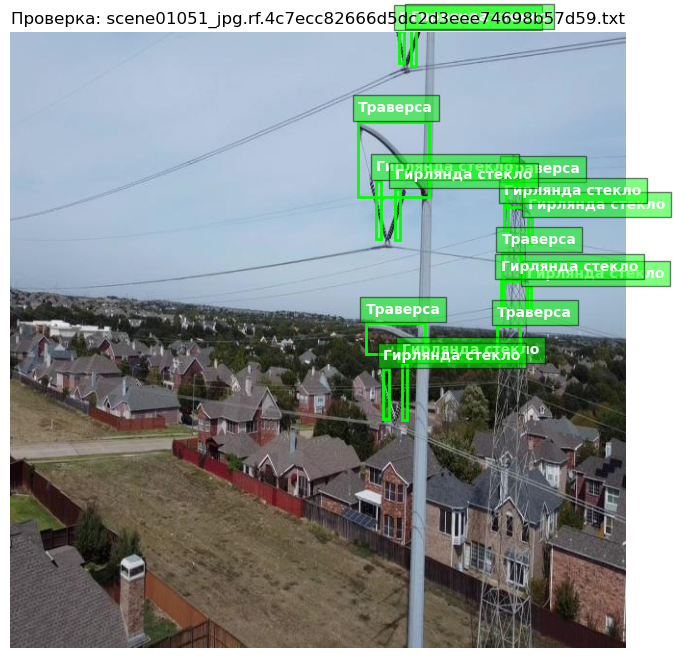

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from PIL import Image
import numpy as np

def check_random_yolo_sample(subset='train'):
    label_dir = f"{DATASET_ROOT}/{subset}/labels"
    img_dir = f"{DATASET_ROOT}/{subset}/images"
    
    all_labels = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    random_label = "scene01051_jpg.rf.4c7ecc82666d5dc2d3eee74698b57d59.txt" 
    base_name = os.path.splitext(random_label)[0]
    
    all_images_in_folder = os.listdir(img_dir)
    img_path = None
    
    for f in all_images_in_folder:
        if os.path.splitext(f)[0] == base_name:
            img_path = os.path.join(img_dir, f)
            break
            
    if not img_path:
        print(f"Картинка для {random_label} не найдена!")
        return
    print(f"Картинка для {random_label} найдена {img_path}!")

    img = Image.open(img_path)
    img_w, img_h = img.size
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img)
    
    rev_cat_map = {v: k for k, v in cat_map.items()}
    id_to_name = {cat['id']: cat['ru_name'] for cat in data['categories']}

    with open(os.path.join(label_dir, random_label), 'r') as f:
        for line in f:
            cls_id, x_c, y_c, w, h = map(float, line.split())
            
            w_px = w * img_w
            h_px = h * img_h
            x_min = (x_c * img_w) - (w_px / 2)
            y_min = (y_c * img_h) - (h_px / 2)
            
            rect = patches.Rectangle((x_min, y_min), w_px, h_px, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            
            orig_id = rev_cat_map[int(cls_id)]
            class_name = id_to_name[orig_id]
            plt.text(x_min, y_min-10, class_name, color='white', weight='bold', bbox=dict(facecolor='lime', alpha=0.5))

    plt.title(f"Проверка: {random_label}")
    plt.axis('off')
    plt.show()

check_random_yolo_sample('train')